In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

import keras

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras
print (keras.__version__)

%matplotlib inline
sns.set(style="white")

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8] # width, height

Using TensorFlow backend.


2.1.4


In [2]:
# Configuration 

# Data sources
include_bitcoin = 1
include_ethereum = 1
include_litecoin = 1
include_ripple = 1
include_goog_trends = 1
include_stocktwits = 0

# Data duration (training + test)
start_date_ = '2015-08-07'
end_date_ = '2018-04-18'

start_date = start_date_.replace("-", "")
end_date = end_date_.replace("-", "")

split_date = '2018-01-20'  # >10% of full dataset

# Target : Predict bitcoin (OR ethereum) daily returns OR volatility 
target = 'btc_daily_ret'
# target = 'btc_volatility'

# target = 'eth_daily_ret'
# target = 'eth_volatility'

# Explore further
# target = 'ltc_daily_ret'
# target = 'xrp_daily_ret'

coins = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
coin_symbol = {'bitcoin': 'btc', 'ethereum': 'eth', 'litecoin': 'ltc', 'ripple': 'xrp'}


In [3]:
# Load dataset
dataset_df = pd.read_pickle("data/full_dataset.pkl")

In [4]:
dataset_df.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


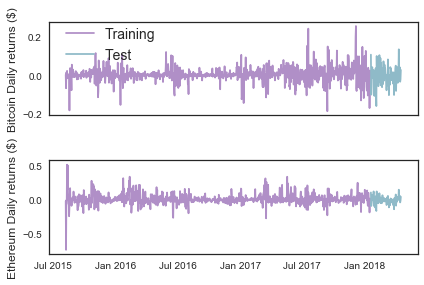

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['btc_daily_ret'], 
         color='#B08FC7', label='Training')
ax1.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['btc_daily_ret'], 
         color='#8FBAC8', label='Test')
ax2.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['eth_daily_ret'], 
         color='#B08FC7')
ax2.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['eth_daily_ret'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Daily returns ($)',fontsize=12)
ax2.set_ylabel('Ethereum Daily returns ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

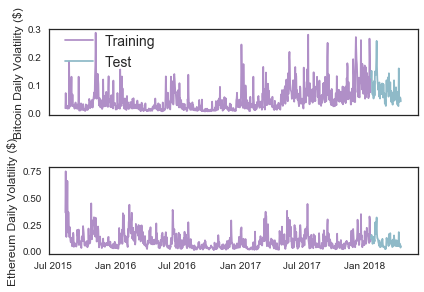

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['btc_volatility'], 
         color='#B08FC7', label='Training')
ax1.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['btc_volatility'], 
         color='#8FBAC8', label='Test')
ax2.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['eth_volatility'], 
         color='#B08FC7')
ax2.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['eth_volatility'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Daily Volatility ($)',fontsize=12)
ax2.set_ylabel('Ethereum Daily Volatility ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

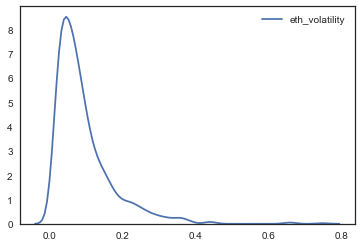

In [7]:
sns.kdeplot(dataset_df['eth_volatility'])

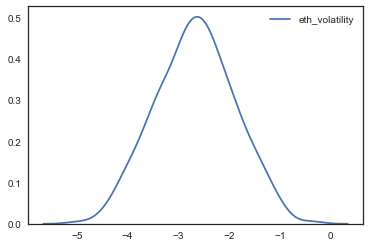

In [8]:
sns.kdeplot(np.log(dataset_df['eth_volatility']))

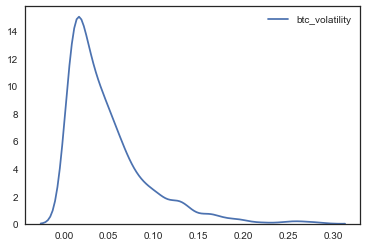

In [9]:
sns.kdeplot(dataset_df['btc_volatility'])

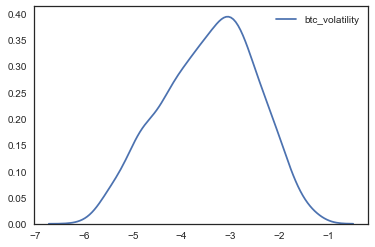

In [10]:
sns.kdeplot(np.log(dataset_df['btc_volatility']))

In [11]:
dataset_df['eth_volatility'] = np.log(dataset_df['eth_volatility'])
dataset_df['btc_volatility'] = np.log(dataset_df['btc_volatility'])

# Benchmarks

Benchmark -I: Price-Persistent model, assumes the close price is same as the previous day. Implies that the estimated daily returns and volatility are both zero

Benchmark - II: Market-Persistent model, assumes the daily returns is same as the previous day. Implies the estimated daily returns and volatility are same as the previous day.

In [12]:
## Price-PERSISTENT MODEL: Benchmark-I

print ("Predicting:", target)

# Evaluate on test dataset
# no change from previous day => pred_bitcoin = 0 (percent change) for persistence model
actual_target = dataset_df[dataset_df['Date']>= split_date][target].values
# pred_target = 0

bm1_mae = np.mean(np.absolute((actual_target)))
bm1_mse = np.mean(np.square((actual_target)))

print("Benchmark-I: MAE", bm1_mae)
print("Benchmark-I: MSE", bm1_mse)

Predicting: btc_daily_ret
Benchmark-I: MAE 0.043559162044812666
Benchmark-I: MSE 0.0030647863135465233


In [13]:
## Market-PERSISTENT MODEL: Benchmark-II

# Evaluate on test dataset
# same market behavior as previous day
pred_target = dataset_df[dataset_df['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)][target][:-1].values

bm2_mae = np.mean(np.absolute((actual_target-pred_target)))
bm2_mse = np.mean(np.square((actual_target-pred_target)))

print("Benchmark-II: MAE", bm2_mae)
print("Benchmark-II: MSE", bm2_mse)

Benchmark-II: MAE 0.06423221532726005
Benchmark-II: MSE 0.006363817757120959


In [14]:
## LSTM Begins
symbols_ = [symbol+"_" for symbol in list(coin_symbol.values())]

model_data = dataset_df
model_data.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


In [15]:
# LSTM Parameters
window_len = 2 # 2 # 7 # 14 # 30

# In test set, include data for the previous "window size" days as well. Only use that data for preparing the inputs for LSTM
training_set, test_set = model_data[model_data['Date']<split_date], \
                         model_data[model_data['Date']>=datetime.datetime.strptime(split_date, '%Y-%m-%d')-datetime.timedelta(days=window_len)]

# we don't need the date columns anymore
########### DONT'WE ?? - If we are to cross-validation, we need the dates!! or we just use the index?
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [16]:
no_of_features = training_set.shape[1]

# Columns to be normalized - Instead of traditional normalization aschemes (like MinMax on training_set), 
# normalize the columns w.r.t to the first element of the window s.t the normalized first element would be 0 
# Reference: 
norm_cols = [[symbol+metric for symbol in symbols_ for metric in ['Close','Volume']]          
             +[coin_symbol[coin]+"_trends" for coin in coins]]

norm_cols

[['btc_Close',
  'btc_Volume',
  'eth_Close',
  'eth_Volume',
  'ltc_Close',
  'ltc_Volume',
  'xrp_Close',
  'xrp_Volume',
  'btc_trends',
  'eth_trends',
  'ltc_trends',
  'xrp_trends']]

In [17]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = training_set[target][window_len:].values

In [18]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = test_set[target][window_len:].values

print(len(training_set))
print(len(test_set))

897
93


In [19]:
# ???  easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

type(LSTM_test_inputs)
print(LSTM_test_inputs.shape, LSTM_training_inputs.shape)

(89, 4, 32) (893, 4, 32)


In [ ]:
# Function to create model, required for KerasRegressor
def create_model(dropout, neurons, activ_func, optimizer):
    # use default values
    loss= 'mse'
    output_size = 1 # TODO: Can we change this to 2 or even 4 (to predict all 4 at a time - {eth, btc}_{volatility, daily_ret})
    
    print ("Start model: ", dropout, neurons)
    
    model = Sequential()

    # Add 3 layers of LSTM, followed by a dense layer
    model.add(LSTM(neurons[0], return_sequences=True, input_shape=(window_len, no_of_features)))
    model.add(Dropout(dropout))
    # from keras.layers.normalization import BatchNormalization
    # model.add(BatchNormalization())
    
    model.add(LSTM(neurons[1], return_sequences=True))
    model.add(Dropout(dropout))
    
    model.add(LSTM(neurons[2]))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    print ("End compilation of model: ", dropout, neurons)
        
    return model

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=2)
# model.fit(predictors, target, validation_split=0.3, epochs=100, callbacks=[early_stopping_monitor])

# create model
model = KerasRegressor(build_fn=create_model, batch_size=4, epochs=15) #, callbacks=[early_stopping_monitor]) 

##############################################################
# grid search: dropout, neurons, optimizer, activation
dropout = [0.4, 0.5, 0.6]  # [0.25, 0.5, 0.75]
neurons = [[10, 8, 4], [20, 16, 8], [40, 32, 16]] # [80, 64, 32], [160, 128, 64]
activations = ['linear', 'tanh'] # , 'linear'] # , 'sigmoid']
optimizer = ['adam', 'sgd', 'rmsprop'] #, 'adam']
param_space = dict(dropout=dropout, neurons=neurons, activ_func=activations, optimizer=optimizer)
##############################################################

tseries_cv = TimeSeriesSplit(n_splits=5).split(LSTM_training_inputs)

grid = GridSearchCV(estimator=model, param_grid=param_space, n_jobs=1, cv=tseries_cv, verbose=5)

print ("Train input shape: ", LSTM_training_inputs.shape)
print ("Train output shape: ", LSTM_training_outputs.shape)

grid_result = grid.fit(LSTM_training_inputs, LSTM_training_outputs)

Train input shape:  (893, 4, 32)
Train output shape:  (893,)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] activ_func=linear, dropout=0.4, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
153/153 [==============================] - 3s 17ms/step - loss: 0.0027
Epoch 2/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 3/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 5/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 6/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 8/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 9/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0014
Epo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0030
Epoch 2/15
301/301 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/15
301/301 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 4/15
301/301 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5/15
301/301 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7/15
301/301 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 8/15
301/301 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 9/15
301/301 [==============================] - 0s 2ms/step - loss: 9.9146e-04
Epoch 10/15
301/301 [==============================] - 0s 2ms/step - loss: 9.3526e-04
Epoch 11/15
301/301 [==============================] - 0s 2ms/step - loss: 9.1881e-04
Epoch 12/15
301/301 [==============================]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.5s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
449/449 [==============================] - 3s 7ms/step - loss: 0.0030
Epoch 2/15
449/449 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 3/15
449/449 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/15
449/449 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 5/15
449/449 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 6/15
449/449 [==============================] - 1s 2ms/step - loss: 9.3522e-04
Epoch 7/15
449/449 [==============================] - 1s 2ms/step - loss: 9.6583e-04
Epoch 8/15
449/449 [==============================] - 1s 2ms/step - loss: 9.4779e-04
Epoch 9/15
449/449 [==============================] - 1s 2ms/step - loss: 8.7864e-04
Epoch 10/15
449/449 [==============================] - 1s 2ms/step - loss: 9.1037e-04
Epoch 11/15
449/449 [==============================] - 1s 2ms/step - loss: 8.9409e-04
Epoch 12/15
449/449 [====================

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.0s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
597/597 [==============================] - 4s 6ms/step - loss: 0.0022
Epoch 2/15
597/597 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 3/15
597/597 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 4/15
597/597 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 5/15
597/597 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 6/15
597/597 [==============================] - 1s 2ms/step - loss: 9.7904e-04
Epoch 7/15
597/597 [==============================] - 1s 2ms/step - loss: 9.9130e-04
Epoch 8/15
597/597 [==============================] - 1s 2ms/step - loss: 9.4375e-04
Epoch 9/15
597/597 [==============================] - 1s 2ms/step - loss: 9.7941e-04
Epoch 10/15
597/597 [==============================] - 1s 2ms/step - loss: 9.3324e-04
Epoch 11/15
597/597 [==============================] - 1s 2ms/step - loss: 9.5254e-04
Epoch 12/15
597/597 [====================

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
745/745 [==============================] - 4s 6ms/step - loss: 0.0018
Epoch 2/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 3/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 9/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 10/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 12/15
745/745 [==============================] - 1s 2ms/ste

745/745 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 4/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 5/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 6/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 7/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 8/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 9/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 10/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 11/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 12/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 13/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 14/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 15/15
745/745 [=============

745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 8/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 9/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 10/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 11/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 12/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 13/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011A: 0s - loss: 0.
Epoch 14/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 15/15
745/74

745/745 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 4/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 9/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 10/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 12/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 13/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 14/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 15/15
745/745 [=============

745/745 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 6/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 7/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 8/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 9/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 10/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 11/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 12/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 13/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 14/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 15/15
745/745 [==============================] - 1s 708us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[20, 16, 8], optimizer=sgd, score=-0.003855717623672398, total=  35.5s
[CV] activ

745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 6/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 9/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 10/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 12/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 13/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 14/15
745/745 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 15/15
745/745 [==============================] - 0s 546us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[20, 16, 8], optimizer=rmsprop, score=-0.003699207049165223, total=  36.9s
[CV] a

745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 6/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 7/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 8/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 9/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 10/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 11/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 12/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 13/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 15/15
745/745 [==============================] - 0s 606us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=adam, score=-0.00374292931263807, total=  41.1s
[CV] acti

745/745 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 8/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0022
Epoch 9/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0020
Epoch 10/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 11/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 12/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 13/15
745/745 [==============================] - ETA: 0s - loss: 0.002 - 2s 2ms/step - loss: 0.0021
Epoch 14/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 15/15
745/745 [==============================] - 0s 659us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=sgd, score=-0.003909340822074965, total=  47.2s
[CV] activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.4 [40, 32, 16]
End compilation of model:  0.4 [40, 32

745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 8/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 9/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 10/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 11/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 12/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 13/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 15/15
745/745 [==============================] - 1s 879us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.0037010611447692862, total=  59.7s
[CV] activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
153/153 [==

745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 9/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 10/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 11/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 12/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 13/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 15/15
745/745 [==============================] - 1s 768us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=adam, score=-0.0037110143709248185, total=  59.3s
[CV] activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=sgd 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
153/153 [==============================] - 17s 108ms/step - loss: 0.0082
Epoch 2/15
153/153 [=====

745/745 [==============================] - 2s 3ms/step - loss: 0.0027
Epoch 11/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 12/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 13/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 14/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0027
Epoch 15/15
745/745 [==============================] - 1s 804us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=sgd, score=-0.0036926144235818552, total=  57.3s
[CV] activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=rmsprop 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
153/153 [==============================] - 18s 121ms/step - loss: 0.0031
Epoch 2/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 3/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 4/15
153/153 [===

745/745 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 11/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 12/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 13/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 15/15
745/745 [==============================] - 1s 738us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=rmsprop, score=-0.00369644316408478, total=  59.2s
[CV] activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
153/153 [==============================] - 20s 130ms/step - loss: 0.0054
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0024
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 4/15
153/153 [=

745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 12/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 13/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 15/15
745/745 [==============================] - 1s 887us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=adam, score=-0.003733514869177393, total= 1.2min
[CV] activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=sgd 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
153/153 [==============================] - 22s 143ms/step - loss: 0.0069
Epoch 2/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 3/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 4/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 5/15
153/153 [====

745/745 [==============================] - 3s 4ms/step - loss: 0.0027
Epoch 14/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 15/15
745/745 [==============================] - 1s 1ms/step
[CV]  activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=sgd, score=-0.0038381786132074035, total= 1.2min
[CV] activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=rmsprop 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
153/153 [==============================] - 26s 170ms/step - loss: 0.0025
Epoch 2/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 3/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 4/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 5/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 6/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 7/15
153/153 [====

745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 15/15
745/745 [==============================] - 1s 847us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=rmsprop, score=-0.003765641441753581, total= 1.3min
[CV] activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=adam 
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
153/153 [==============================] - 25s 162ms/step - loss: 0.0051
Epoch 2/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0021
Epoch 5/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 6/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 7/15
153/153 

745/745 [==============================] - 4s 5ms/step - loss: 0.0011
Epoch 14/15
745/745 [==============================] - 4s 5ms/step - loss: 0.0012
Epoch 15/15
745/745 [==============================] - 1s 912us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=adam, score=-0.0036918992905034306, total= 1.5min
[CV] activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=sgd 
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
153/153 [==============================] - 26s 173ms/step - loss: 0.0045
Epoch 2/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0032
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0032
Epoch 6/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 7/15
153/153 [=

Epoch 15/15
745/745 [==============================] - 1s 1ms/step
[CV]  activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=sgd, score=-0.0038009418013471813, total= 1.4min
[CV] activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
153/153 [==============================] - 30s 193ms/step - loss: 0.0044
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 4/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 6/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 7/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 8/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0016
Epoch 9/15

745/745 [==============================] - 1s 963us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.0037000738791264027, total= 1.5min
[CV] activ_func=linear, dropout=0.6, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.6 [10, 8, 4]
End compilation of model:  0.6 [10, 8, 4]
Epoch 1/15
153/153 [==============================] - 34s 223ms/step - loss: 0.0129
Epoch 2/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 3/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 4/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 5/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 6/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 7/15
153/153 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 8/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 9/15
153/153 [=====

745/745 [==============================] - 1s 1ms/step
[CV]  activ_func=linear, dropout=0.6, neurons=[10, 8, 4], optimizer=adam, score=-0.003696330594991466, total= 1.7min
[CV] activ_func=linear, dropout=0.6, neurons=[10, 8, 4], optimizer=sgd 
Start model:  0.6 [10, 8, 4]
End compilation of model:  0.6 [10, 8, 4]
Epoch 1/15
153/153 [==============================] - 41s 265ms/step - loss: 0.0022
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0021
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 6/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 9/15
153/153 [==============

End compilation of model:  0.6 [10, 8, 4]
Epoch 1/15
153/153 [==============================] - 43s 281ms/step - loss: 0.0087
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0040
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0027
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0025
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 6/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 7/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 10/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 11/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 12/15
153/153 [==============================] - 1s 4ms/

Epoch 1/15
153/153 [==============================] - 48s 314ms/step - loss: 0.0078
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0081
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 5/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0031
Epoch 6/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0029
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0027
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0021
Epoch 10/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 11/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 12/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0013
Epoch 13/15
153/153 [=

153/153 [==============================] - 1s 6ms/step - loss: 0.0076
Epoch 3/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 4/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0070
Epoch 5/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 6/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 7/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0057A: 0s - 
Epoch 8/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0053
Epoch 9/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 10/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0047A: 0s - los
Epoch 11/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0056
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 13/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0047
Epoch 14/15
153/

153/153 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 5/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 6/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0017
Epoch 7/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 8/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014A: 0s - loss:
Epoch 9/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 10/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 11/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 13/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 14/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 15/15
153/153 [==============================] - 0s 1ms/step
[CV]  activ_func=linear, dropout=0.

153/153 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 5/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 6/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0018
Epoch 7/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0019
Epoch 8/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0017
Epoch 9/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0019
Epoch 10/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0016
Epoch 11/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0018
Epoch 12/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0015
Epoch 13/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0016
Epoch 14/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0012
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=linear, dropout=0.6, neurons=[4

153/153 [==============================] - 1s 6ms/step - loss: 0.0061
Epoch 6/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 7/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 8/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 9/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 10/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0047
Epoch 11/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0045
Epoch 12/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0054
Epoch 13/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 14/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0047
Epoch 15/15
153/153 [==============================] - 0s 1ms/step
[CV]  activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=sgd, score=-0.0007862911690018656, total= 1.7min
[CV] activ

153/153 [==============================] - 1s 6ms/step - loss: 0.0015
Epoch 8/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0016
Epoch 9/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 10/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 11/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 13/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 14/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.0006304690472756487, total= 1.9min
[CV] activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.6 [40, 32, 16]
End compilation of model:  0.6 [40, 32, 16]
Epoch 1/15
301/

153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 8/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 9/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 10/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 11/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 13/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 14/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0011
Epoch 15/15
153/153 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=adam, score=-0.0006590500431991893, total= 2.0min
[CV] activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
301/301 [=============

153/153 [==============================] - 1s 6ms/step - loss: 0.0026
Epoch 9/15
153/153 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 10/15
153/153 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 11/15
153/153 [==============================] - 1s 8ms/step - loss: 0.0023
Epoch 12/15
153/153 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 13/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 14/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=sgd, score=-0.0008113061563022171, total= 2.2min
[CV] activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=sgd .
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
301/301 [==============================] - 77s 255ms/step - loss: 0.0049
Epoch 2/15
301/301 [===========

153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 11/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 13/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 14/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=rmsprop, score=-0.000636468939774204, total= 2.1min
[CV] activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=rmsprop 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
301/301 [==============================] - 83s 274ms/step - loss: 0.0032
Epoch 2/15
301/301 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 3/15
301/301 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 4/15
301/301 [======

153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 11/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 13/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 14/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=adam, score=-0.0006602632799292002, total= 2.4min
[CV] activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.4 [20, 16, 8]
End compilation of model:  0.4 [20, 16, 8]
Epoch 1/15
301/301 [==============================] - 129s 429ms/step - loss: 0.0036
Epoch 2/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0017
Epoch 3/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0013
Epoch 4/15
301/301 [======

Epoch 11/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0029
Epoch 12/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0029
Epoch 13/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 14/15
153/153 [==============================] - 1s 6ms/step - loss: 0.0029
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=sgd, score=-0.0007056348702069561, total= 2.9min
[CV] activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=sgd 
Start model:  0.4 [20, 16, 8]
End compilation of model:  0.4 [20, 16, 8]
Epoch 1/15
301/301 [==============================] - 126s 418ms/step - loss: 0.0050
Epoch 2/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0033
Epoch 3/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0037
Epoch 4/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0037
Epoch 5/15
301/30

153/153 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 14/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=rmsprop, score=-0.0007079796235523867, total= 3.5min
[CV] activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=rmsprop 
Start model:  0.4 [20, 16, 8]
End compilation of model:  0.4 [20, 16, 8]
Epoch 1/15
301/301 [==============================] - 131s 436ms/step - loss: 0.0022
Epoch 2/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0014
Epoch 3/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0012
Epoch 4/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 5/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0010
Epoch 6/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0010
Epoch 7/15
301/301 [===

153/153 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 14/15
153/153 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=adam, score=-0.0006447996039315587, total= 3.2min
[CV] activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=adam 
Start model:  0.4 [40, 32, 16]
End compilation of model:  0.4 [40, 32, 16]
Epoch 1/15
301/301 [==============================] - 90s 299ms/step - loss: 0.0019
Epoch 2/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 3/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 4/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 5/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0010
Epoch 7/15
301/301 [======

153/153 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 14/15
153/153 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=sgd, score=-0.0007571931503637618, total= 2.6min
[CV] activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=sgd 
Start model:  0.4 [40, 32, 16]
End compilation of model:  0.4 [40, 32, 16]
Epoch 1/15
301/301 [==============================] - 96s 319ms/step - loss: 0.0043
Epoch 2/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0038
Epoch 3/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0030
Epoch 4/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0031
Epoch 5/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0029
Epoch 6/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0029
Epoch 7/15
301/301 [========

153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.0006556666315658289, total= 2.7min
[CV] activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.4 [40, 32, 16]
End compilation of model:  0.4 [40, 32, 16]
Epoch 1/15
301/301 [==============================] - 103s 343ms/step - loss: 0.0022
Epoch 2/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0015
Epoch 3/15
301/301 [==============================] - 3s 11ms/step - loss: 0.0013
Epoch 4/15
301/301 [==============================] - 3s 11ms/step - loss: 0.0011
Epoch 5/15
301/301 [==============================] - 3s 9ms/step - loss: 9.9379e-04
Epoch 6/15
301/301 [==============================] - 3s 8ms/step - loss: 9.9789e-04
Epoch 7/15
301/301 [==============================] - 2s 8ms/step - loss: 9.4742e-04
Epoch 8/15
301/301 [==============================] - 2s 7ms/step - loss: 9.9367e-04
Epo

Epoch 15/15
153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=adam, score=-0.000642570739580913, total= 3.0min
[CV] activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
301/301 [==============================] - 114s 378ms/step - loss: 0.0036
Epoch 2/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 3/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0016
Epoch 4/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 5/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 7/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 8/15
301/301 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 9/15
301/301 [====

153/153 [==============================] - 0s 2ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=sgd, score=-0.0006570519415716361, total= 3.5min
[CV] activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=sgd .
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
301/301 [==============================] - 137s 455ms/step - loss: 0.0108
Epoch 2/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0093
Epoch 3/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0072
Epoch 4/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0072
Epoch 5/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0066
Epoch 6/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0076
Epoch 7/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0056
Epoch 8/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0064
Epoch 9/15
301/301 [================

End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
301/301 [==============================] - 159s 527ms/step - loss: 0.0019
Epoch 2/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0013
Epoch 3/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0011
Epoch 4/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0010
Epoch 5/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0011
Epoch 7/15
301/301 [==============================] - 3s 9ms/step - loss: 9.1176e-04
Epoch 8/15
301/301 [==============================] - 3s 9ms/step - loss: 9.7064e-04
Epoch 9/15
301/301 [==============================] - 3s 9ms/step - loss: 9.2011e-04
Epoch 10/15
301/301 [==============================] - 3s 9ms/step - loss: 8.9935e-04
Epoch 11/15
301/301 [==============================] - 3s 9ms/step - loss: 9.4869e-04
Epoch 12/15
301/301 [====================

301/301 [==============================] - 138s 458ms/step - loss: 0.0047
Epoch 2/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 3/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0015
Epoch 4/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 5/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 6/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 7/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 8/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 9/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0010
Epoch 10/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 11/15
301/301 [==============================] - 2s 7ms/step - loss: 9.6063e-04
Epoch 12/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0010
Epoch 13/15
301/301 [=======

301/301 [==============================] - 2s 7ms/step - loss: 0.0044
Epoch 3/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0042
Epoch 4/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0033
Epoch 5/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0033
Epoch 6/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0028
Epoch 7/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 8/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 9/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 10/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0031
Epoch 11/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0025
Epoch 12/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0026
Epoch 13/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0026
Epoch 14/15
301/301 [==============

301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 5/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 6/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0010
Epoch 7/15
301/301 [==============================] - 2s 7ms/step - loss: 9.3776e-04
Epoch 8/15
301/301 [==============================] - 2s 7ms/step - loss: 0.0010
Epoch 9/15
301/301 [==============================] - 2s 8ms/step - loss: 9.6557e-04
Epoch 10/15
301/301 [==============================] - 2s 7ms/step - loss: 9.4716e-04
Epoch 11/15
301/301 [==============================] - 2s 8ms/step - loss: 9.8210e-04
Epoch 12/15
301/301 [==============================] - 2s 8ms/step - loss: 9.1378e-04
Epoch 13/15
301/301 [==============================] - 2s 8ms/step - loss: 9.4225e-04
Epoch 14/15
301/301 [==============================] - 2s 7ms/step - loss: 9.0972e-04
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=tan

301/301 [==============================] - 3s 10ms/step - loss: 0.0012
Epoch 5/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0010
Epoch 7/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 8/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0010
Epoch 9/15
301/301 [==============================] - 3s 10ms/step - loss: 9.6427e-04
Epoch 10/15
301/301 [==============================] - 3s 10ms/step - loss: 9.9778e-04
Epoch 11/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0010
Epoch 12/15
301/301 [==============================] - 3s 10ms/step - loss: 9.7105e-04
Epoch 13/15
301/301 [==============================] - 3s 10ms/step - loss: 9.1971e-04
Epoch 14/15
301/301 [==============================] - 3s 10ms/step - loss: 9.5438e-04
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=

301/301 [==============================] - 3s 10ms/step - loss: 0.0033
Epoch 5/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0034
Epoch 6/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0032
Epoch 7/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0026
Epoch 8/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0033
Epoch 9/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0033
Epoch 10/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0027
Epoch 11/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0026
Epoch 12/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0028
Epoch 13/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0025
Epoch 14/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0027
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[

301/301 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 3s 10ms/step - loss: 0.0010
Epoch 7/15
301/301 [==============================] - 3s 10ms/step - loss: 9.6193e-04
Epoch 8/15
301/301 [==============================] - 3s 10ms/step - loss: 9.5440e-04
Epoch 9/15
301/301 [==============================] - 3s 10ms/step - loss: 9.6547e-04
Epoch 10/15
301/301 [==============================] - 3s 10ms/step - loss: 9.3422e-04
Epoch 11/15
301/301 [==============================] - 3s 10ms/step - loss: 9.4856e-04
Epoch 12/15
301/301 [==============================] - 3s 10ms/step - loss: 9.4186e-04
Epoch 13/15
301/301 [==============================] - 3s 10ms/step - loss: 8.9697e-04
Epoch 14/15
301/301 [==============================] - 3s 10ms/step - loss: 9.4889e-04
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.0

Epoch 5/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 6/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0010
Epoch 7/15
301/301 [==============================] - 3s 9ms/step - loss: 0.0010
Epoch 8/15
301/301 [==============================] - 3s 9ms/step - loss: 9.7548e-04
Epoch 9/15
301/301 [==============================] - 3s 8ms/step - loss: 9.6051e-04
Epoch 10/15
301/301 [==============================] - 3s 9ms/step - loss: 9.6653e-04
Epoch 11/15
301/301 [==============================] - 2s 8ms/step - loss: 9.5484e-04
Epoch 12/15
301/301 [==============================] - 2s 8ms/step - loss: 9.0328e-04
Epoch 13/15
301/301 [==============================] - 3s 9ms/step - loss: 9.2972e-04
Epoch 14/15
301/301 [==============================] - 3s 8ms/step - loss: 9.1860e-04
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[10, 8, 4], optimizer=adam, score=-0.000709128

301/301 [==============================] - 2s 8ms/step - loss: 0.0026
Epoch 7/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 8/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0027
Epoch 9/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 10/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 11/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0021
Epoch 12/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 13/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0023
Epoch 14/15
301/301 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[10, 8, 4], optimizer=sgd, score=-0.0009033614593086846, total= 4.9min
[CV] activ_func=tanh, dropout=0.6, neurons=[10, 8, 4], optimizer=sgd .
Start model:  0.6 [10, 8

301/301 [==============================] - 3s 8ms/step - loss: 9.0205e-04
Epoch 9/15
301/301 [==============================] - 3s 8ms/step - loss: 9.4289e-04
Epoch 10/15
301/301 [==============================] - 3s 8ms/step - loss: 8.9871e-04
Epoch 11/15
301/301 [==============================] - 3s 9ms/step - loss: 8.9354e-04
Epoch 12/15
301/301 [==============================] - 3s 8ms/step - loss: 9.0640e-04
Epoch 13/15
301/301 [==============================] - 3s 8ms/step - loss: 9.1727e-04
Epoch 14/15
301/301 [==============================] - 3s 8ms/step - loss: 9.0762e-04
Epoch 15/15
301/301 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[10, 8, 4], optimizer=rmsprop, score=-0.0007407643551158725, total= 5.2min
[CV] activ_func=tanh, dropout=0.6, neurons=[10, 8, 4], optimizer=rmsprop 
Start model:  0.6 [10, 8, 4]
End compilation of model:  0.6 [10, 8, 4]
Epoch 1/15
449/449 [==============================] - 184s 410ms/step - loss: 0.

In [ ]:
# fig, ax1 = plt.subplots(1,1)

# ax1.plot(bt_history.epoch, bt_history.history['loss'])
# ax1.set_title('Training Error')

# if bt_model.loss == 'mae':
#     ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# elif bt_model.loss == 'mse':
#     ax1.set_ylabel('Mean Squared Error (MSE)',fontsize=12)
# else:
#     ax1.set_ylabel('Model Loss',fontsize=12)
# ax1.set_xlabel('# Epochs',fontsize=12)
# plt.show()

In [ ]:
# print(grid_result.cv_results_)
df = pd.DataFrame(grid_result.cv_results_)
# df['params'] = df['params'].values # Use apply() or lambda()
# pd.set_option('max_colwidth',200)

df['active_func'] = [ x['activ_func'] for x in df['params'].values]
df['dropout'] = [ x['dropout'] for x in df['params'].values]
df['neurons'] = [ x['neurons'] for x in df['params'].values]
df['optimizer'] = [ x['optimizer'] for x in df['params'].values]
df.drop(columns='params', inplace=True)

df[['active_func', 'dropout', 'neurons', 'optimizer', 'mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score']]

In [ ]:
bt_model = grid_result.best_estimator_
print(grid_result.best_params_.values())
print(grid_result.best_score_)

# Sensitivity Analysis

Add random noise (with normal distribution) to training and test inputs, and study the mean & variance of the final model's predictions

In [ ]:
training_set_

In [ ]:
training_set.std()

In [ ]:
num_iter = 5
lstm_test_mse = []
lstm_train_mse = []

for i in range(num_iter):
    training_set_rand = training_set + (np.random.rand(*training_set.shape)*training_set.std().values)/10
    test_set_rand = test_set + (np.random.rand(*test_set.shape)*test_set.std().values)/10


    LSTM_training_inputs_rand = []
    for i in range(len(training_set_rand)-window_len):
        temp_set = training_set_rand[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_training_inputs_rand.append(temp_set)
        
    LSTM_test_inputs_rand = []
    for i in range(len(test_set_rand)-window_len):
        temp_set = test_set_rand[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_test_inputs_rand.append(temp_set)

    # Convert to numpy arrays
    LSTM_training_inputs_rand = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs_rand]
    LSTM_training_inputs_rand = np.array(LSTM_training_inputs_rand)

    LSTM_test_inputs_rand = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs_rand]
    LSTM_test_inputs_rand = np.array(LSTM_test_inputs_rand)

    lstm_test_mse.append(np.mean(np.square(bt_model.predict(LSTM_test_inputs_rand)-(test_set[target].values[window_len:]))))
    lstm_train_mse.append(np.mean(np.square(bt_model.predict(LSTM_training_inputs_rand)-(training_set[target].values[window_len:]))))

print (lstm_test_mse)
print (lstm_train_mse)

print (np.mean(lstm_test_mse), np.std(lstm_test_mse))
print (np.mean(lstm_train_mse), np.std(lstm_train_mse))

# print(LSTM_training_inputs)

In [ ]:
print (np.mean(lstm_test_mse), np.std(lstm_test_mse))
print (np.mean(lstm_train_mse), np.std(lstm_train_mse))

In [ ]:
fig, ax1 = plt.subplots(1,1)
LSTM_test_outputs = training_set[target][window_len:].values
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'].astype(datetime.datetime),
         test_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'].astype(datetime.datetime),
         (bt_model.predict(LSTM_test_inputs)), 
         label='Predicted')
lstm_mse=np.mean(np.square(bt_model.predict(LSTM_test_inputs)-(test_set[target].values[window_len:])))
ax1.annotate('MSE: %.4f'%lstm_mse, xy=(0.75, 0.9),  xycoords='axes fraction', xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Volatilty',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_training_inputs)), 
         label='Predicted')
ax1.annotate('MSE: %.4f'%np.mean(np.square(bt_model.predict(LSTM_training_inputs)-\
            (training_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Training Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Volatility',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
pred_values = bt_model.predict(LSTM_training_inputs)
max(pred_values)
min(pred_values)

In [ ]:
print (bm1_mse)
print (bm2_mse)
print (lstm_mse)

In [ ]:
temp = create_model(0.5, [10, 8, 4], 'linear', 'adam')

temp.summary()

Log (Bitcoin Volatility) :

{'activ_func': 'linear', 'dropout': 0.4, 'neurons': [20, 16, 8]}
7.188424481804465
0.2821991334719368
0.2323832191539962

Log (Ethereum Volatility):

7.075934943743348
0.26612587735504156
0.250099288542878

Bitcoin Daily returns:

0.0030647863135465233
0.006363817757120959
0.003059795171523061
{'activ_func': 'linear', 'dropout': 0.4, 'neurons': [10, 8, 4]}

Ethereum Daily returns:

{'activ_func': 'linear', 'dropout': 0.5, 'neurons': [10, 8, 4]}
0.003542452975106516
0.007433466612293294
0.003664957524689988